In [95]:
# %% Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

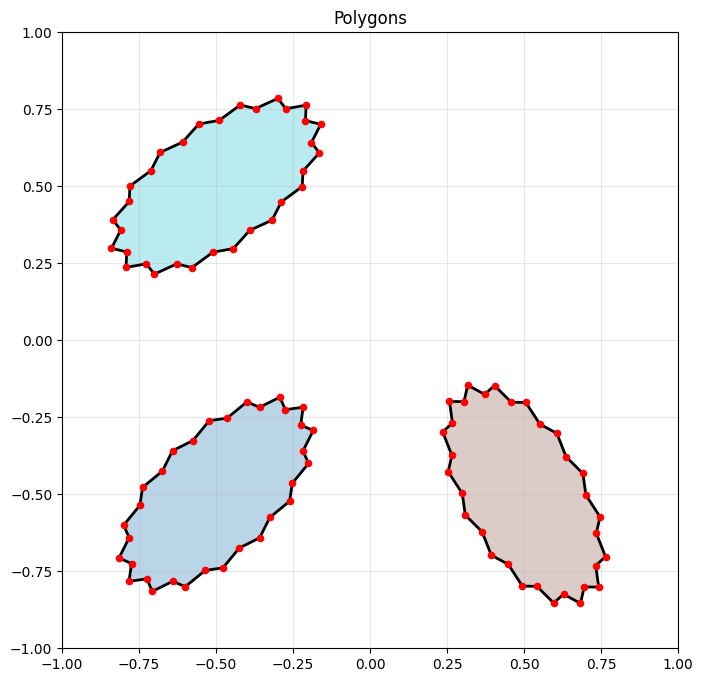

In [96]:
from ainr import generate_polygons, plot_polygons


polygons = generate_polygons('3x16', convex=False, stretch=(1, 0.5), star_ratio=0.9, rotation=[np.pi/4, -np.pi/3, np.pi/5])
plot_polygons(polygons)

In [ ]:
def robust_pca(vertices: np.ndarray):
    """
    Compute robust PCA with deterministic orientation.
    Works for any dimension (2D, 3D, etc.).
    
    Args:
        vertices: (N, D) array of points
    
    Returns:
        center: (D,) centroid
        axes: (D, D) principal axes (rows are axes, sorted by variance)
        eigenvalues: (D,) variances along each axis
    """
    center = vertices.mean(axis=0)
    centered = vertices - center
    n_dims = vertices.shape[1]
    
    # Covariance
    cov = centered.T @ centered / len(vertices)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort descending by variance
    order = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[order]
    axes = eigenvectors[:, order].T.copy()
    
    # Near-equal variance: prefer coordinate-alignment for most dominant axis
    # (Only check first two axes if they exist)
    if n_dims >= 2 and eigenvalues[0] > 1e-10:
        ratio = eigenvalues[1] / eigenvalues[0]
        if ratio > 0.99:
            # Swap if second axis is more aligned with first coordinate
            if abs(axes[1, 0]) > abs(axes[0, 0]):
                axes[[0, 1]] = axes[[1, 0]]
                eigenvalues[[0, 1]] = eigenvalues[[1, 0]]
    
    # Deterministic sign: point towards where more mass lies
    # Fallback to positive coordinate direction if mass is nearly balanced
    for i in range(n_dims):
        # Project centered points onto this axis
        projections = centered @ axes[i]
        mass_sum = projections.sum()
        
        # If mass is nearly balanced (within 10% of total spread)
        mass_threshold = 0.1 * np.abs(projections).sum()
        
        if abs(mass_sum) < mass_threshold:
            # Fallback: prefer positive direction along first non-zero coordinate
            for dim in range(n_dims):
                if abs(axes[i, dim]) > 1e-10:
                    if axes[i, dim] < 0:
                        axes[i] *= -1
                    break
        else:
            # Use mass-based direction
            if mass_sum < 0:
                axes[i] *= -1
    
    return center, axes, eigenvalues

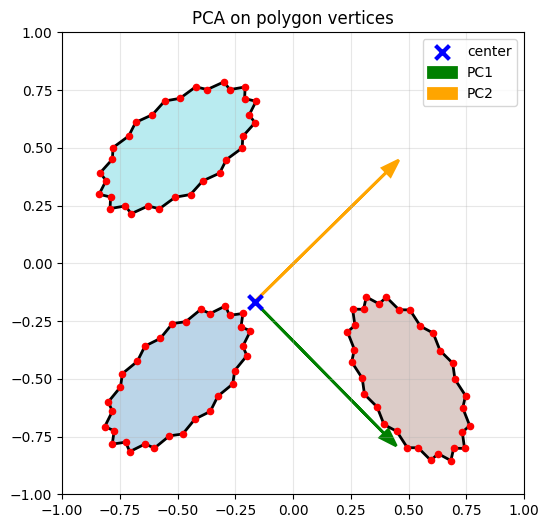

In [98]:
vertices = np.concatenate(polygons, axis=0)
center, axes, variances = robust_pca(vertices)

# Visualize
plt.figure(figsize=(6, 6))

# Draw each polygon with fill and outline (like plot_polygons)
colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
for i, polygon in enumerate(polygons):
    # Close polygon by adding first vertex at end
    closed_poly = np.vstack([polygon, polygon[0:1]])
    plt.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=2)
    plt.fill(closed_poly[:, 0], closed_poly[:, 1], color=colors[i], alpha=0.3)

# Mark all vertices
plt.scatter(vertices[:, 0], vertices[:, 1], c='red', s=20, zorder=5)

# Draw center
plt.scatter(*center, c='blue', s=100, marker='x', lw=3, zorder=10, label='center')

# Draw PCA axes
for i, (ax, col) in enumerate(zip(axes, ['green', 'orange'])):
    plt.arrow(center[0], center[1], ax[0]*0.8, ax[1]*0.8, 
              head_width=0.05, color=col, lw=2, label=f'PC{i+1}')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('PCA on polygon vertices')
plt.show()

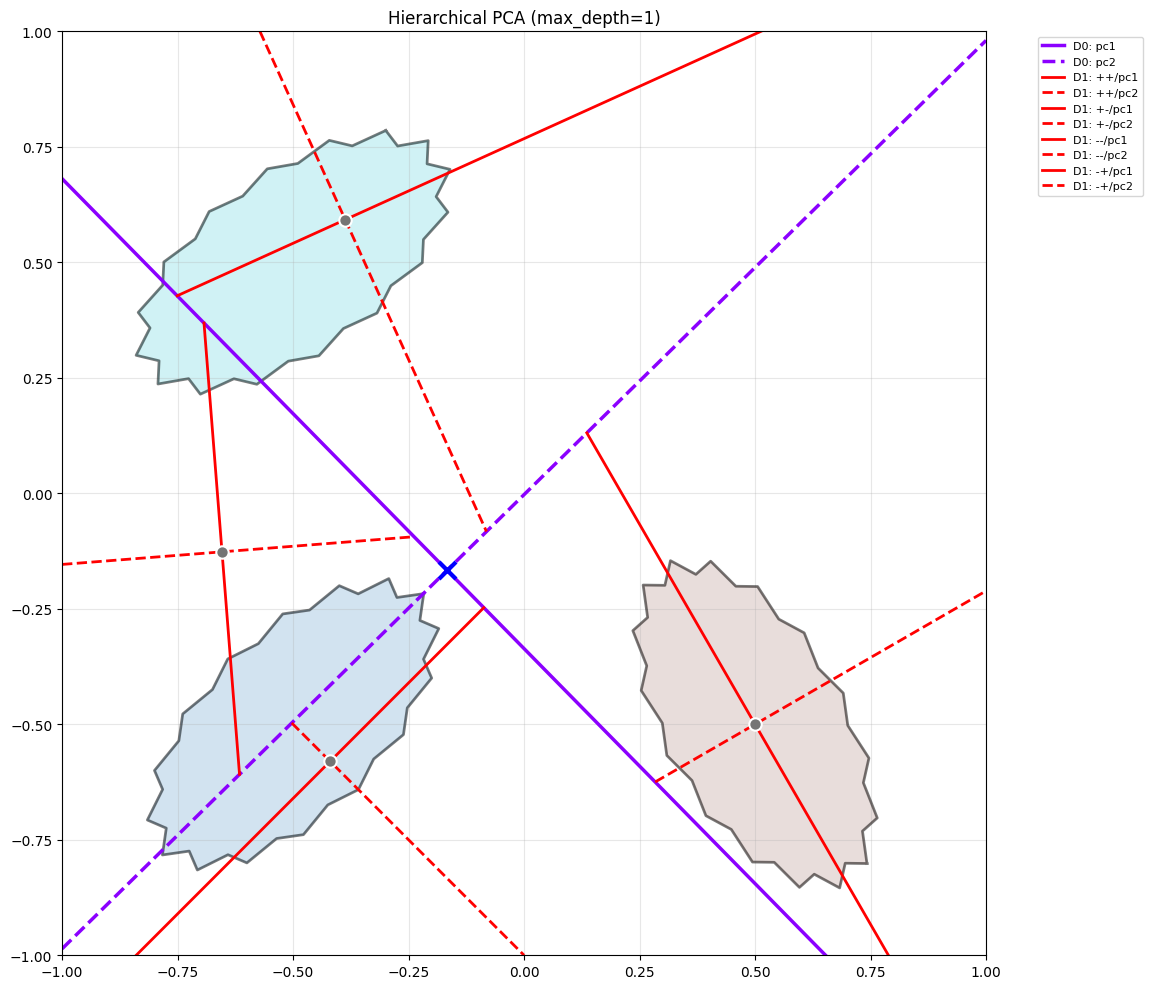

In [99]:
def clip_line(origin, direction, halfspace_normals=None, halfspace_points=None, box_min=-1, box_max=1):
    """Clip line to region, return (t_min, t_max) or (None, None)."""
    direction = direction / np.linalg.norm(direction)
    t_min, t_max = -np.inf, np.inf
    
    # Clip to box
    for i in range(2):
        if abs(direction[i]) > 1e-12:
            t1 = (box_min - origin[i]) / direction[i]
            t2 = (box_max - origin[i]) / direction[i]
            t_min = max(t_min, min(t1, t2))
            t_max = min(t_max, max(t1, t2))
        elif origin[i] < box_min or origin[i] > box_max:
            return None, None
    
    # Clip to half-spaces
    if halfspace_normals is not None:
        for normal, point in zip(halfspace_normals, halfspace_points):
            d_dot_n = np.dot(direction, normal)
            if abs(d_dot_n) > 1e-12:
                t_boundary = np.dot(point - origin, normal) / d_dot_n
                if d_dot_n > 0:
                    t_min = max(t_min, t_boundary)
                else:
                    t_max = min(t_max, t_boundary)
            elif np.dot(point - origin, normal) < 0:
                return None, None
    
    return (t_min, t_max) if t_min <= t_max else (None, None)


def build_hierarchical_pca(vertices, max_depth=2, box_min=-1, box_max=1, 
                           halfspace_normals=None, halfspace_points=None):
    """
    Build hierarchical PCA. Returns dict: {'pc1': (p_start, p_end), 'pc2': (p_start, p_end), '++': {...}, ...}
    
    halfspace_normals/halfspace_points: accumulated constraints from ALL parent levels
    """
    if len(vertices) < 3:
        return None
    
    center, axes, variances = robust_pca(vertices)
    
    # Create line segments for PC1 and PC2
    lines = {}
    for i, pc_key in enumerate(['pc1', 'pc2']):
        t_range = clip_line(center, axes[i], halfspace_normals, halfspace_points, box_min, box_max)
        if t_range[0] is not None:
            direction = axes[i] / np.linalg.norm(axes[i])
            p_start = center + t_range[0] * direction
            p_end = center + t_range[1] * direction
            lines[pc_key] = (p_start, p_end)
    
    node = {'center': center, 'axes': axes, 'variances': variances, **lines}
    
    # Recurse into quadrants
    if max_depth > 0:
        proj = (vertices - center) @ axes.T
        for s1, s2, key in [(1, 1, '++'), (1, -1, '+-'), (-1, -1, '--'), (-1, 1, '-+')]:
            mask = ((np.sign(proj[:, 0]) == s1) | (proj[:, 0] == 0)) & \
                   ((np.sign(proj[:, 1]) == s2) | (proj[:, 1] == 0))
            
            # Accumulate half-spaces: add current level's constraints to existing ones
            new_normals = list(halfspace_normals) if halfspace_normals else []
            new_points = list(halfspace_points) if halfspace_points else []
            new_normals.extend([s1 * axes[0], s2 * axes[1]])
            new_points.extend([center, center])
            
            child = build_hierarchical_pca(vertices[mask], max_depth - 1, box_min, box_max,
                                          new_normals, new_points)
            if child is not None:
                node[key] = child
    
    return node


def plot_hierarchical_pca(node, polygons, depth=0, max_depth=2, path='', quadrant_idx=0):
    """Plot hierarchical PCA structure."""
    if depth == 0:
        plt.figure(figsize=(12, 10))
        
        # Draw polygons
        poly_colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
        for i, polygon in enumerate(polygons):
            closed_poly = np.vstack([polygon, polygon[0:1]])
            plt.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=2, alpha=0.5)
            plt.fill(closed_poly[:, 0], closed_poly[:, 1], color=poly_colors[i], alpha=0.2)
    
    if node is None:
        return
    
    # One color per depth level
    depth_colors = ['#8B00FF', '#FF0000', '#00C853', '#00B8D4']  # Purple, Red, Green, Cyan
    
    color = depth_colors[min(depth, len(depth_colors)-1)]
    alpha = 1.0  # No transparency
    
    # Draw center
    marker_size = 150 if depth == 0 else 80
    center_color = ['#0000FF', '#757575', '#BDBDBD'][min(depth, 2)]  # Blue → gray → light gray
    plt.scatter(*node['center'], s=marker_size, 
                marker='x' if depth == 0 else 'o', c=center_color,
                linewidth=3 if depth == 0 else 1.5, zorder=10-depth, alpha=alpha,
                edgecolors=None if depth == 0 else 'white')
    
    # Draw lines - pc1 solid, pc2 dashed
    for pc_idx, pc_key in enumerate(['pc1', 'pc2']):
        if pc_key not in node:
            continue
        
        p_start, p_end = node[pc_key]
        label = f"D{depth}: {path}{pc_key}" if path else f"D{depth}: {pc_key}"
        
        # pc1 = solid line, pc2 = dashed line
        linestyle = '-' if pc_key == 'pc1' else '--'
        
        plt.plot([p_start[0], p_end[0]], [p_start[1], p_end[1]], 
                 color=color, lw=2.5 if depth == 0 else 2, ls=linestyle, 
                 alpha=alpha, label=label)
    
    # Recurse to quadrant children
    for q_idx, quad_key in enumerate(['++', '+-', '--', '-+']):
        if quad_key in node:
            new_path = f"{path}{quad_key}/" if path else f"{quad_key}/"
            plot_hierarchical_pca(node[quad_key], polygons, depth + 1, max_depth, new_path, q_idx)
    
    if depth == 0:
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.gca().set_aspect('equal')
        plt.grid(alpha=0.3)
        
        # Place legend to the right of the plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=1)
        plt.title(f'Hierarchical PCA (max_depth={max_depth})')
        plt.tight_layout()
        plt.show()

# Example: Build hierarchical structure with max_depth=1
hierarchy = build_hierarchical_pca(vertices, max_depth=1)

# Visualize
plot_hierarchical_pca(hierarchy, polygons, max_depth=1)

Computing SDF for 10 lines...


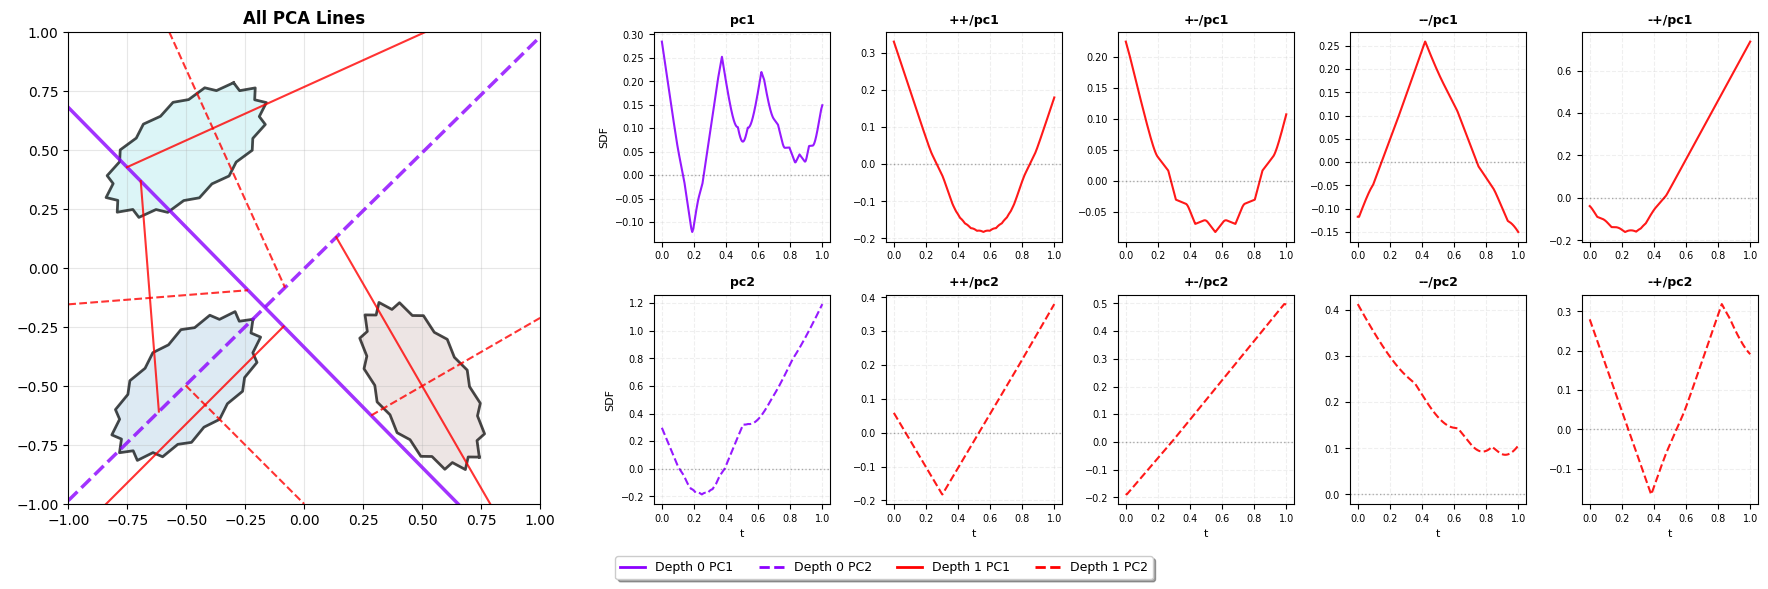

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def compute_sdf_sampling(p_start, p_end, polygons, n_samples=1000):
    """Compute SDF along line segment."""
    # Sample line
    t = np.linspace(0, 1, n_samples)
    points = p_start + t[:, None] * (p_end - p_start)
    
    # Sample polygon edges (50 points per edge)
    poly_samples = []
    for poly in polygons:
        for i in range(len(poly)):
            v1, v2 = poly[i], poly[(i + 1) % len(poly)]
            poly_samples.append(v1 + np.linspace(0, 1, 50, endpoint=False)[:, None] * (v2 - v1))
    poly_samples = np.vstack(poly_samples)
    
    # Find nearest distances using KD-tree
    distances = KDTree(poly_samples).query(points)[0]
    
    # Vectorized inside/outside check (ray casting)
    inside = np.zeros(len(points), dtype=bool)
    for poly in polygons:
        v = np.asarray(poly)
        v_next = np.roll(v, -1, axis=0)
        
        # Check ray crossings for all points at once
        py = points[:, 1:2]  # Shape (N, 1)
        v_y, v_next_y = v[:, 1], v_next[:, 1]
        
        # Edges that potentially cross the ray
        crosses = ((v_y <= py) & (py < v_next_y)) | ((v_next_y <= py) & (py < v_y))
        
        # Compute x-intersections
        t_cross = (py - v_y) / (v_next_y - v_y + 1e-10)
        x_cross = v[:, 0] + t_cross * (v_next[:, 0] - v[:, 0])
        
        # Count crossings to the right of each point
        inside |= (np.sum(crosses & (x_cross > points[:, 0:1]), axis=1) % 2 == 1)
    
    return t, np.where(inside, -distances, distances)


def plot_sdf_fancy(line_segments, labels, polygons, n_samples=1000):
    """
    Plot SDF curves: 2D visualization on left, individual SDF plots on right.
    Each line gets its own plot.
    """
    # Compute SDF for all lines
    all_data = []
    for (p_start, p_end), label in zip(line_segments, labels):
        t, sdf = compute_sdf_sampling(p_start, p_end, polygons, n_samples)
        depth = int(label.split(':')[0].replace('D', '')) if 'D' in label else 0
        pc_type = 'pc1' if 'pc1' in label else 'pc2'
        all_data.append({'t': t, 'sdf': sdf, 'label': label, 'line': (p_start, p_end),
                        'depth': depth, 'pc_type': pc_type})
    
    # Separate PC1 and PC2
    pc1_data = [d for d in all_data if d['pc_type'] == 'pc1']
    pc2_data = [d for d in all_data if d['pc_type'] == 'pc2']
    
    depth_colors = ['#8B00FF', '#FF0000', '#00C853', '#00B8D4']
    
    # Calculate number of columns: 1 (2D plot) + number of individual plots
    n_plots = max(len(pc1_data), len(pc2_data))
    
    # Create figure with gridspec
    fig = plt.figure(figsize=(18, 6))
    import matplotlib.gridspec as gridspec
    
    # Width ratios: 2 for 2D plot, then 0.6 for each individual plot
    width_ratios = [2] + [0.6] * n_plots
    gs = gridspec.GridSpec(3, n_plots + 1, figure=fig, 
                          height_ratios=[10, 10, 1], 
                          width_ratios=width_ratios)
    
    # Left: 2D visualization (spans both rows)
    ax_2d = fig.add_subplot(gs[0:2, 0])
    
    # Draw polygons
    poly_colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
    for j, poly in enumerate(polygons):
        poly_closed = np.vstack([poly, poly[0]])
        ax_2d.plot(poly_closed[:, 0], poly_closed[:, 1], 'k-', linewidth=2, alpha=0.7)
        ax_2d.fill(poly_closed[:, 0], poly_closed[:, 1], color=poly_colors[j], alpha=0.15)
    
    # Draw all lines
    for data in all_data:
        p_start, p_end = data['line']
        color = depth_colors[min(data['depth'], len(depth_colors)-1)]
        ls = '-' if data['pc_type'] == 'pc1' else '--'
        lw = 2.5 if data['depth'] == 0 else 1.5
        
        ax_2d.plot([p_start[0], p_end[0]], [p_start[1], p_end[1]], 
                   color=color, ls=ls, lw=lw, alpha=0.8)
    
    ax_2d.set_xlim(-1, 1)
    ax_2d.set_ylim(-1, 1)
    ax_2d.set_aspect('equal')
    ax_2d.grid(alpha=0.3)
    ax_2d.set_title('All PCA Lines', fontsize=12, fontweight='bold')
    
    # Right: Individual SDF plots
    # Top row: PC1
    for idx, data in enumerate(pc1_data):
        ax = fig.add_subplot(gs[0, idx + 1])
        color = depth_colors[min(data['depth'], len(depth_colors)-1)]
        
        ax.plot(data['t'], data['sdf'], color=color, ls='-', lw=1.5, alpha=0.9)
        ax.axhline(0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.grid(alpha=0.2, linestyle='--')
        
        # Extract short label (just the path part)
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        ax.set_title(short_label, fontsize=9, fontweight='bold')
        
        if idx == 0:
            ax.set_ylabel('SDF', fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Bottom row: PC2
    for idx, data in enumerate(pc2_data):
        ax = fig.add_subplot(gs[1, idx + 1])
        color = depth_colors[min(data['depth'], len(depth_colors)-1)]
        
        ax.plot(data['t'], data['sdf'], color=color, ls='--', lw=1.5, alpha=0.9)
        ax.axhline(0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.grid(alpha=0.2, linestyle='--')
        
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        ax.set_title(short_label, fontsize=9, fontweight='bold')
        ax.set_xlabel('t', fontsize=8)
        
        if idx == 0:
            ax.set_ylabel('SDF', fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Bottom: Legend (spans all columns)
    ax_legend = fig.add_subplot(gs[2, :])
    ax_legend.axis('off')
    
    # Create legend handles
    from matplotlib.lines import Line2D
    legend_handles = []
    
    # Get unique depths present in data
    depths = sorted(set(d['depth'] for d in all_data))
    for depth in depths:
        color = depth_colors[min(depth, len(depth_colors)-1)]
        legend_handles.append(Line2D([0], [0], color=color, lw=2, ls='-', 
                                     label=f'Depth {depth} PC1'))
        legend_handles.append(Line2D([0], [0], color=color, lw=2, ls='--', 
                                     label=f'Depth {depth} PC2'))
    
    ax_legend.legend(handles=legend_handles, loc='center', ncol=6, fontsize=9, 
                    frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()


# Extract all lines from hierarchy
def extract_all_lines(node, depth=0, path='', result=None):
    """Recursively extract all (p_start, p_end) tuples with labels."""
    if result is None:
        result = []
    if node is None:
        return result
    
    for pc in ['pc1', 'pc2']:
        if pc in node:
            label = f"D{depth}: {path}{pc}" if path else f"D{depth}: {pc}"
            result.append((node[pc], label))
    
    for quad in ['++', '+-', '--', '-+']:
        if quad in node:
            extract_all_lines(node[quad], depth + 1, f"{path}{quad}/", result)
    
    return result

# Get all lines
all_lines_data = extract_all_lines(hierarchy)
line_segments = [line for line, _ in all_lines_data]
labels = [label for _, label in all_lines_data]

print(f"Computing SDF for {len(line_segments)} lines...")

# Plot everything
plot_sdf_fancy(line_segments, labels, polygons, n_samples=1000)

In [ ]:
import numpy as np

def simplify_sdf_to_knots(t_values, sdf_values, tolerance=0.005):
    """Simplify SDF to knots using Douglas-Peucker algorithm."""
    
    def perpendicular_distance(point_idx, start_idx, end_idx):
        x0, y0 = t_values[point_idx], sdf_values[point_idx]
        x1, y1 = t_values[start_idx], sdf_values[start_idx]
        x2, y2 = t_values[end_idx], sdf_values[end_idx]
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            return np.sqrt((x0 - x1)**2 + (y0 - y1)**2)
        return abs(dy * x0 - dx * y0 + x2 * y1 - y2 * x1) / np.sqrt(dx**2 + dy**2)
    
    def douglas_peucker(start_idx, end_idx):
        max_dist, max_idx = 0, start_idx
        for i in range(start_idx + 1, end_idx):
            dist = perpendicular_distance(i, start_idx, end_idx)
            if dist > max_dist:
                max_dist, max_idx = dist, i
        
        if max_dist > tolerance:
            left = douglas_peucker(start_idx, max_idx)
            right = douglas_peucker(max_idx, end_idx)
            return left + right[1:]
        return [start_idx, end_idx]
    
    # Douglas-Peucker
    keep = sorted(set(douglas_peucker(0, len(t_values) - 1)))
    
    knot_t, knot_sdf = t_values[keep], sdf_values[keep]
    
    # Compute error
    sdf_interp = np.interp(t_values, knot_t, knot_sdf)
    max_error = np.max(np.abs(sdf_values - sdf_interp))
    mean_error = np.mean(np.abs(sdf_values - sdf_interp))
    
    return knot_t, knot_sdf, max_error, mean_error


# Compute knots for all lines from previous cell
print(f"Computing knots for {len(line_segments)} lines...")
all_knots = []

for (p_start, p_end), label in zip(line_segments, labels):
    t, sdf = compute_sdf_sampling(p_start, p_end, polygons, n_samples=1000)
    knot_t, knot_sdf, max_err, mean_err = simplify_sdf_to_knots(t, sdf, tolerance=0.005)
    
    depth = int(label.split(':')[0].replace('D', '')) if 'D' in label else 0
    pc_type = 'pc1' if 'pc1' in label else 'pc2'
    
    all_knots.append({
        't': t, 'sdf': sdf,
        'knot_t': knot_t, 'knot_sdf': knot_sdf,
        'max_error': max_err, 'mean_error': mean_err,
        'label': label, 'line': (p_start, p_end),
        'depth': depth, 'pc_type': pc_type
    })
    
    print(f"  {label}: {len(knot_t)} knots, max_err={max_err:.6f}")

print("\nDone!")

Computing knots for 10 lines...
  D0: pc1: 23 knots, max_err=0.009386
  D0: pc2: 20 knots, max_err=0.010152
  D1: ++/pc1: 16 knots, max_err=0.005407
  D1: ++/pc2: 7 knots, max_err=0.002263
  D1: +-/pc1: 19 knots, max_err=0.004960
  D1: +-/pc2: 7 knots, max_err=0.000414
  D1: --/pc1: 12 knots, max_err=0.006029
  D1: --/pc2: 11 knots, max_err=0.004603
  D1: -+/pc1: 14 knots, max_err=0.003642
  D1: -+/pc2: 11 knots, max_err=0.002862

Done!


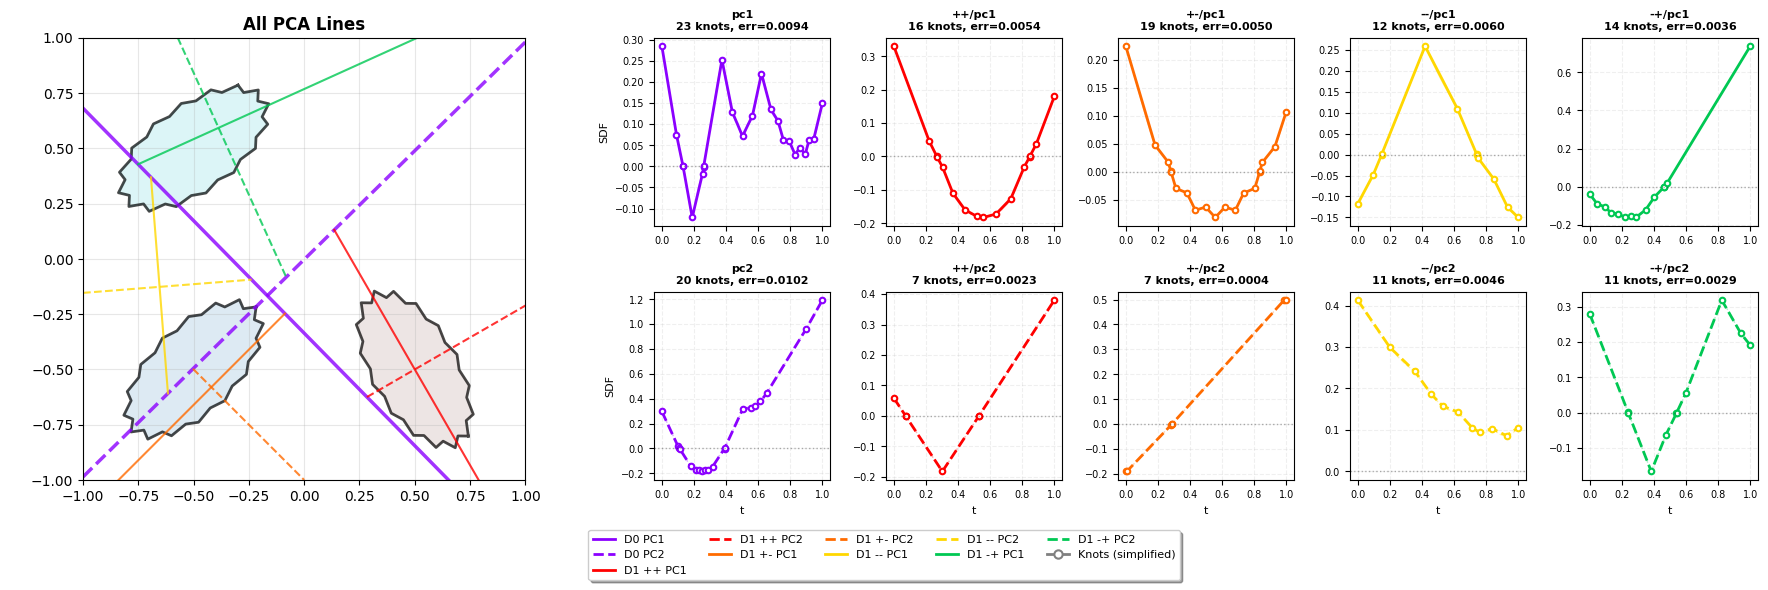


Knot Summary:
Label                Knots    Max Error    Mean Error   Compression
---------------------------------------------------------------------------
pc1                  23       0.009386     0.002531     2.3%
pc2                  20       0.010152     0.002120     2.0%
++/pc1               16       0.005407     0.001275     1.6%
++/pc2               7        0.002263     0.000707     0.7%
+-/pc1               19       0.004960     0.001085     1.9%
+-/pc2               7        0.000414     0.000017     0.7%
--/pc1               12       0.006029     0.001586     1.2%
--/pc2               11       0.004603     0.001992     1.1%
-+/pc1               14       0.003642     0.000678     1.4%
-+/pc2               11       0.002862     0.000678     1.1%


In [102]:
# Plot with knots overlay
def plot_sdf_with_knots(all_knots_data, polygons):
    """Plot SDF curves with knot overlays and error information."""
    
    # Separate PC1 and PC2
    pc1_data = [d for d in all_knots_data if d['pc_type'] == 'pc1']
    pc2_data = [d for d in all_knots_data if d['pc_type'] == 'pc2']
    
    # Color mapping function
    def get_color_for_data(data):
        depth = data['depth']
        label = data['label']
        
        # D0: Purple
        if depth == 0:
            return '#8B00FF'
        
        # D1: Unique color per quadrant
        elif depth == 1:
            quadrant_colors = {
                '++': '#FF0000',  # Red
                '+-': '#FF6B00',  # Orange  
                '--': '#FFD700',  # Gold
                '-+': '#00C853'   # Green
            }
            # Extract quadrant from label (e.g., "D1: ++/pc1" -> "++")
            for quad in ['++', '+-', '--', '-+']:
                if quad in label:
                    return quadrant_colors[quad]
            return '#FF0000'  # Fallback
        
        # D2+: Cyan/Blue
        else:
            return '#00B8D4'
    
    n_plots = max(len(pc1_data), len(pc2_data))
    
    # Create figure
    fig = plt.figure(figsize=(18, 6))
    import matplotlib.gridspec as gridspec
    width_ratios = [2] + [0.6] * n_plots
    gs = gridspec.GridSpec(3, n_plots + 1, figure=fig, 
                          height_ratios=[10, 10, 1], 
                          width_ratios=width_ratios)
    
    # Left: 2D visualization
    ax_2d = fig.add_subplot(gs[0:2, 0])
    poly_colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
    for j, poly in enumerate(polygons):
        poly_closed = np.vstack([poly, poly[0]])
        ax_2d.plot(poly_closed[:, 0], poly_closed[:, 1], 'k-', linewidth=2, alpha=0.7)
        ax_2d.fill(poly_closed[:, 0], poly_closed[:, 1], color=poly_colors[j], alpha=0.15)
    
    for data in all_knots_data:
        p_start, p_end = data['line']
        color = get_color_for_data(data)
        ls = '-' if data['pc_type'] == 'pc1' else '--'
        lw = 2.5 if data['depth'] == 0 else 1.5
        ax_2d.plot([p_start[0], p_end[0]], [p_start[1], p_end[1]], 
                   color=color, ls=ls, lw=lw, alpha=0.8)
    
    ax_2d.set_xlim(-1, 1)
    ax_2d.set_ylim(-1, 1)
    ax_2d.set_aspect('equal')
    ax_2d.grid(alpha=0.3)
    ax_2d.set_title('All PCA Lines', fontsize=12, fontweight='bold')
    
    # Right: Individual plots with knots
    # Top row: PC1
    for idx, data in enumerate(pc1_data):
        ax = fig.add_subplot(gs[0, idx + 1])
        color = get_color_for_data(data)
        
        # Plot dense SDF (thin, transparent)
        ax.plot(data['t'], data['sdf'], color=color, ls='-', lw=1, alpha=0.3)
        
        # Plot knots (thick, opaque)
        ax.plot(data['knot_t'], data['knot_sdf'], 'o-', color=color, 
                lw=2, markersize=4, alpha=1.0, markerfacecolor='white', 
                markeredgewidth=1.5, markeredgecolor=color)
        
        ax.axhline(0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.grid(alpha=0.2, linestyle='--')
        
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        ax.set_title(f"{short_label}\n{len(data['knot_t'])} knots, err={data['max_error']:.4f}", 
                    fontsize=8, fontweight='bold')
        
        if idx == 0:
            ax.set_ylabel('SDF', fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Bottom row: PC2
    for idx, data in enumerate(pc2_data):
        ax = fig.add_subplot(gs[1, idx + 1])
        color = get_color_for_data(data)
        
        # Plot dense SDF (thin, transparent)
        ax.plot(data['t'], data['sdf'], color=color, ls='--', lw=1, alpha=0.3)
        
        # Plot knots (thick, opaque)
        ax.plot(data['knot_t'], data['knot_sdf'], 'o--', color=color, 
                lw=2, markersize=4, alpha=1.0, markerfacecolor='white', 
                markeredgewidth=1.5, markeredgecolor=color)
        
        ax.axhline(0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.grid(alpha=0.2, linestyle='--')
        
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        ax.set_title(f"{short_label}\n{len(data['knot_t'])} knots, err={data['max_error']:.4f}", 
                    fontsize=8, fontweight='bold')
        ax.set_xlabel('t', fontsize=8)
        
        if idx == 0:
            ax.set_ylabel('SDF', fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Bottom: Legend
    ax_legend = fig.add_subplot(gs[2, :])
    ax_legend.axis('off')
    
    from matplotlib.lines import Line2D
    legend_handles = []
    
    # D0: Purple
    legend_handles.append(Line2D([0], [0], color='#8B00FF', lw=2, ls='-', 
                                 label='D0 PC1'))
    legend_handles.append(Line2D([0], [0], color='#8B00FF', lw=2, ls='--', 
                                 label='D0 PC2'))
    
    # D1 quadrants with unique colors
    d1_colors = {
        '++': ('#FF0000', 'Red'),
        '+-': ('#FF6B00', 'Orange'),
        '--': ('#FFD700', 'Gold'),
        '-+': ('#00C853', 'Green')
    }
    
    for quad, (color, name) in d1_colors.items():
        legend_handles.append(Line2D([0], [0], color=color, lw=2, ls='-', 
                                     label=f'D1 {quad} PC1'))
        legend_handles.append(Line2D([0], [0], color=color, lw=2, ls='--', 
                                     label=f'D1 {quad} PC2'))
    
    # Add knot explanation
    legend_handles.append(Line2D([0], [0], color='gray', lw=2, marker='o', 
                                 markerfacecolor='white', markeredgewidth=1.5,
                                 label='Knots (simplified)'))
    
    ax_legend.legend(handles=legend_handles, loc='center', ncol=5, fontsize=8, 
                    frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nKnot Summary:")
    print(f"{'Label':<20} {'Knots':<8} {'Max Error':<12} {'Mean Error':<12} {'Compression'}")
    print("-" * 75)
    for data in all_knots_data:
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        compression = 100 * len(data['knot_t']) / len(data['t'])
        print(f"{short_label:<20} {len(data['knot_t']):<8} {data['max_error']:<12.6f} "
              f"{data['mean_error']:<12.6f} {compression:.1f}%")

# Plot everything with knots
plot_sdf_with_knots(all_knots, polygons)

In [103]:
def merge_hierarchy_with_data(hierarchy, all_knots_data):
    """Merge hierarchy structure with knots/SDF data. Returns enriched hierarchy."""
    
    # Create lookup by label
    data_by_label = {}
    for data in all_knots_data:
        label = data['label']
        # Extract path from label (e.g., "D0: pc1" -> "pc1", "D1: ++/pc1" -> "++/pc1")
        if ': ' in label:
            path = label.split(': ')[1]
        else:
            path = label
        data_by_label[path] = data
    
    def merge_node(node, path=''):
        """Recursively merge node with data."""
        if node is None:
            return None
        
        enriched = {}
        
        # Merge PC1 and PC2
        for pc_key in ['pc1', 'pc2']:
            if pc_key in node:
                line = node[pc_key]
                full_path = f"{path}/{pc_key}" if path else pc_key
                
                # Find matching data
                if full_path in data_by_label:
                    data = data_by_label[full_path]
                    enriched[pc_key] = {
                        'line': line,  # (p_start, p_end)
                        't': data['t'],
                        'sdf': data['sdf'],
                        'knot_t': data['knot_t'],
                        'knot_sdf': data['knot_sdf'],
                        'max_error': data['max_error'],
                        'mean_error': data['mean_error'],
                        'depth': data['depth'],
                        'label': data['label']
                    }
                else:
                    # No data found, just store line
                    enriched[pc_key] = {'line': line}
        
        # Recursively merge children
        for quad_key in ['++', '+-', '--', '-+']:
            if quad_key in node:
                child_path = f"{path}/{quad_key}" if path else quad_key
                enriched[quad_key] = merge_node(node[quad_key], child_path)
        
        return enriched
    
    return merge_node(hierarchy)


# Create enriched hierarchy
enriched_hierarchy = merge_hierarchy_with_data(hierarchy, all_knots)

# Demo: Access data easily
print("Enriched Hierarchy Structure:\n")
print(f"Root PC1: {enriched_hierarchy['pc1']['line']}")
print(f"  Knots: {len(enriched_hierarchy['pc1']['knot_t'])}")
print(f"  Max Error: {enriched_hierarchy['pc1']['max_error']:.6f}\n")

print(f"Root PC2: {enriched_hierarchy['pc2']['line']}")
print(f"  Knots: {len(enriched_hierarchy['pc2']['knot_t'])}")
print(f"  Max Error: {enriched_hierarchy['pc2']['max_error']:.6f}\n")

# Check children
if '++' in enriched_hierarchy:
    print("Quadrant '++' exists:")
    if 'pc1' in enriched_hierarchy['++']:
        pc1_data = enriched_hierarchy['++']['pc1']
        print(f"  PC1: {pc1_data['line']}")
        print(f"    Knots: {len(pc1_data['knot_t'])}")
        print(f"    Max Error: {pc1_data['max_error']:.6f}")

Enriched Hierarchy Structure:

Root PC1: (array([-1.        ,  0.68100762]), array([ 0.65256833, -1.        ]))
  Knots: 23
  Max Error: 0.009386

Root PC2: (array([-1.        , -0.98590167]), array([1.        , 0.98026233]))
  Knots: 20
  Max Error: 0.010152

Quadrant '++' exists:
  PC1: (array([0.13584789, 0.13072995]), array([ 0.78867513, -1.        ]))
    Knots: 16
    Max Error: 0.005407


In [104]:
print(enriched_hierarchy['pc1']['knot_t'])
print(enriched_hierarchy['pc1']['knot_sdf'])

[0.         0.09109109 0.13113113 0.13213213 0.18918919 0.25325325
 0.26026026 0.26126126 0.37437437 0.43943944 0.5025025  0.56456456
 0.62062062 0.67967968 0.72372372 0.75675676 0.79479479 0.83083083
 0.85785786 0.89389389 0.91691692 0.94694695 1.        ]
[ 0.28458976  0.07479986  0.00160901 -0.00031247 -0.1211966  -0.01737561
 -0.00116441  0.00133351  0.25228632  0.12829074  0.07156076  0.12013225
  0.21969201  0.13481793  0.10741704  0.06301947  0.05884311  0.02719596
  0.04415003  0.02909895  0.06188227  0.06564915  0.14898427]


In [105]:
import torch
from ainr import ReluMLP
import torch

def compute_layer_weights(x_prev, x_new, c):
    """
    Compute weights A and biases b for a layer to place knots at x_new.
    
    Args:
        x_prev: Previous layer knots (sorted), shape (n_prev,)
        x_new: New knots for this layer, shape (n_neurons, n_prev + 1)
               x_new[j, nu] should be in interval (x_prev[nu-1], x_prev[nu])
               with x_prev[-1] = -inf, x_prev[n_prev] = +inf convention
        c: Source channel values, shape (n_neurons,)
    
    Returns:
        A: Weight matrix, shape (n_neurons, n_prev)
        b: Bias vector, shape (n_neurons,)
    """
    n_prev = len(x_prev)
    n_neurons = len(c)
    
    # Compute slopes mu[j, nu] on each interval
    # mu[j, 0] = c[j]  (slope for t -> -inf)
    # mu[j, nu] = mu[j, nu-1] * (x_prev[nu-1] - x_new[j, nu-1]) / (x_prev[nu-1] - x_new[j, nu])
    
    mu = torch.zeros(n_neurons, n_prev + 1)
    mu[:, 0] = c
    
    for nu in range(1, n_prev + 1):
        x_boundary = x_prev[nu - 1]  # The boundary knot
        x_zero_prev = x_new[:, nu - 1]  # Previous zero crossing
        x_zero_curr = x_new[:, nu]  # Current zero crossing
        
        # Avoid division by zero
        denom = x_boundary - x_zero_curr
        denom = torch.where(torch.abs(denom) < 1e-10, torch.ones_like(denom) * 1e-10, denom)
        
        mu[:, nu] = mu[:, nu - 1] * (x_boundary - x_zero_prev) / denom
    
    # Weight matrix: A[j, k] = mu[j, k+1] - mu[j, k]
    A = mu[:, 1:] - mu[:, :-1]
    
    # Bias: places the first zero crossing at x_new[j, 0]
    # f_j(x_new[j,0]) = 0  =>  c[j] * x_new[j,0] + b[j] = 0  =>  b[j] = -c[j] * x_new[j,0]
    b = -c * x_new[:, 0]
    
    return A, b

def fit_output_scale(mlp, target_knots, target_values):
    """
    Adjust output layer weights to best match target values at knots.
    Simple least-squares fit.
    """
    with torch.no_grad():
        t = target_knots.unsqueeze(1) if target_knots.dim() == 1 else target_knots
        y_pred = mlp(t).squeeze()
        y_target = target_values.float()  # Changed from torch.tensor(target_values)
        
        # Scale factor: minimize ||scale * y_pred - y_target||^2
        scale = (y_pred @ y_target) / (y_pred @ y_pred + 1e-10)
        
        # Apply scale to output weights
        mlp.layers[-1].weight.data *= scale
        mlp.layers[-1].bias.data *= scale
        
        return scale.item()

def evaluate_and_compare(mlp, target_knots, target_values):
    """Evaluate network and compare to target."""
    with torch.no_grad():
        t = target_knots.unsqueeze(1) if target_knots.dim() == 1 else target_knots
        y_pred = mlp(t).squeeze().numpy()
    
    import numpy as np
    y_target = np.array(target_values)
    
    error = np.abs(y_pred - y_target)
    print(f"Max error: {error.max():.6f}")
    print(f"Mean error: {error.mean():.6f}")
    print(f"Predictions: {y_pred}")
    print(f"Targets:     {y_target}")
    
    return y_pred, y_target

hidden_dim = 4
num_layers = 3

mlp = ReluMLP(1, hidden_dim, num_layers, skip_connections=True)
for layer in mlp.layers:
    layer.weight.data.zero_()
    layer.bias.data.zero_()

knots = torch.tensor(enriched_hierarchy['pc1']['knot_t'], dtype=torch.float32)
values = torch.tensor(enriched_hierarchy['pc1']['knot_sdf'], dtype=torch.float32)

indices = torch.linspace(0, len(knots)-1, hidden_dim).long()
x_first = knots[indices].sort()[0]

mlp.layers[0].weight.data.fill_(1.0)
mlp.layers[0].bias.data = x_first

# Source channels
c1 = torch.tensor([(-1.0)**(j+1) for j in range(hidden_dim)])
c2 = torch.tensor([(-1.0)**(j+1) for j in range(hidden_dim)])

mlp.layers[1].weight.data[:, -1] = c1
mlp.layers[2].weight.data[:, -1] = c2
mlp.layers[3].weight.data[:, -1] = 0.0

# === LAYER 1: Second-level knots ===
x_second = torch.zeros(hidden_dim, hidden_dim+1)
for nu in range(hidden_dim+1):
    left = x_first[nu-1].item() if nu > 0 else x_first[0].item() - 1.0
    right = x_first[nu].item() if nu < hidden_dim else x_first[-1].item() + 1.0
    x_second[:, nu] = torch.linspace(left + 0.01, right - 0.01, hidden_dim)

A1, b1 = compute_layer_weights(x_first, x_second, c1)
mlp.layers[1].weight.data[:, :hidden_dim] = A1
mlp.layers[1].bias.data = b1

# === LAYER 2: Keep simple (identity-like or small) ===
mlp.layers[2].weight.data[:, :hidden_dim] = torch.eye(hidden_dim) * 0.1
mlp.layers[2].bias.data.zero_()

# === OUTPUT: Sum ===
mlp.layers[3].weight.data[:, :hidden_dim].fill_(1.0)
mlp.layers[3].bias.data.zero_()

# === FIT SCALE ===
scale = fit_output_scale(mlp, knots, values)

In [106]:
import torch

mlp = ReluMLP(input_dim=1, hidden_dim=4, num_layers=3, skip_connections=True)

n1 = 4
n2 = 4
n3 = 4
num_breakpoints = n2*n3 + n1*n2 + n1 + n2 + n3

knots = torch.linspace(0, 1, num_breakpoints)
values = torch.sin(knots * 2 * np.pi)

# 1. Setup
n1, n2, n3 = 4, 4, 4
num_breakpoints = n2*n3 + n1*n2 + n1 + n2 + n3  # 44